# **Assignment 3 ROB313 - Optimization**

In [2]:
# Import revelant libraries

import numpy as np
import matplotlib.pyplot as plt
from time import time
from data.data_utils import load_dataset
from scipy.linalg import cho_factor, cho_solve, svd
import math
import scipy.special

**Question 1 - Variants of Gradient Descent**

Observations:
- Range of good learning rates, too small results in no convergence, too large results in loss beginning small and becoming extremely large (asymptotic to inf, causes overflow errors)
- Increasing learning rate increases convergence rate
- Increased learning rate decreases epoch (no. of iterations until convergence condition is met)

Time of convergence: 0.14383935928344727 for eta=0.001 at iteration 3174 (Full Batch)
Time of convergence: 0.01884770393371582 for eta=0.01 at iteration 316 (Full Batch)
Time of convergence: 0.0 for eta=1 at iteration 1 (Full Batch)
Time of convergence: 0.1393749713897705 for eta=0.001 at iteration 1830 (Mini Batch 10)
Time of convergence: 0.056047916412353516 for eta=0.01 at iteration 658 (Mini Batch 10)
Time of convergence: 0.6160309314727783 for eta=0.001 at iteration 7059 (Mini Batch 1, Beta=0.1)
Time of convergence: 0.4096956253051758 for eta=0.001 at iteration 4558 (Mini Batch 1, Beta=0.5)
Time of convergence: 0.3020634651184082 for eta=0.001 at iteration 4347 (Mini Batch 1, Beta=0.65)
Time of convergence: 0.3139667510986328 for eta=0.001 at iteration 4721 (Mini Batch 1, Beta=0.9)


(1.0904753653424812, 1.0766462109278265, 1.0172036473238795, 0.5)

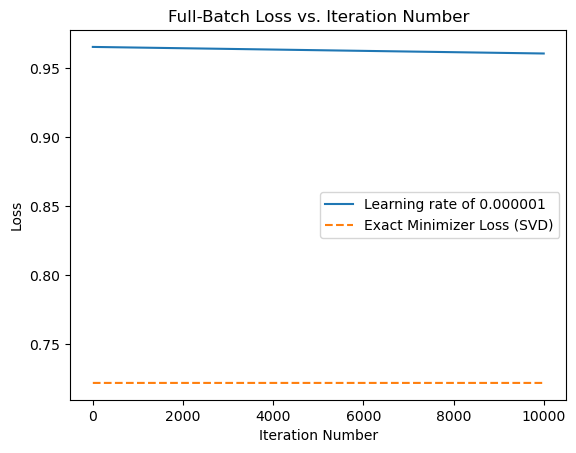

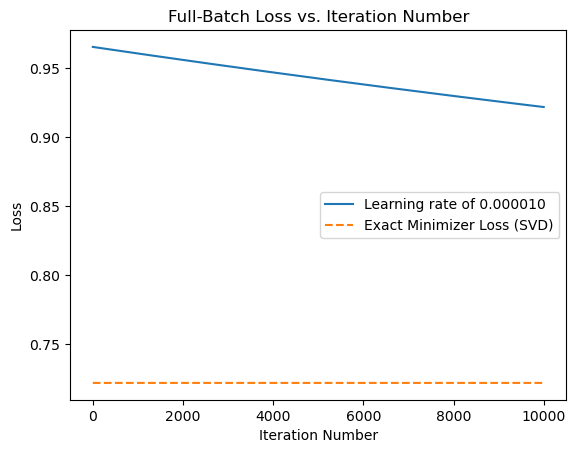

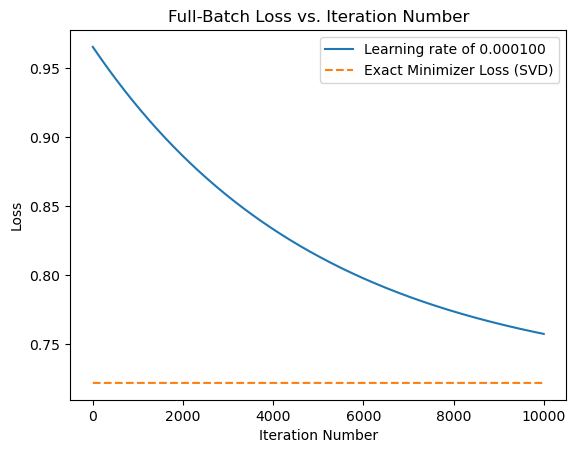

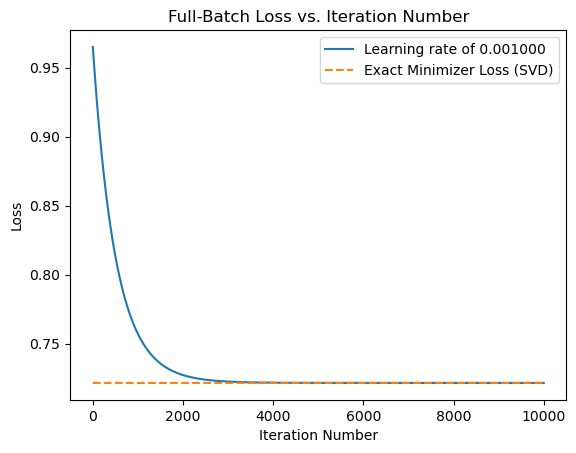

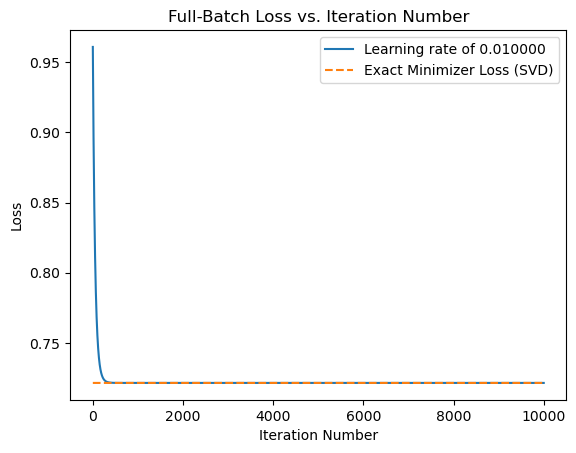

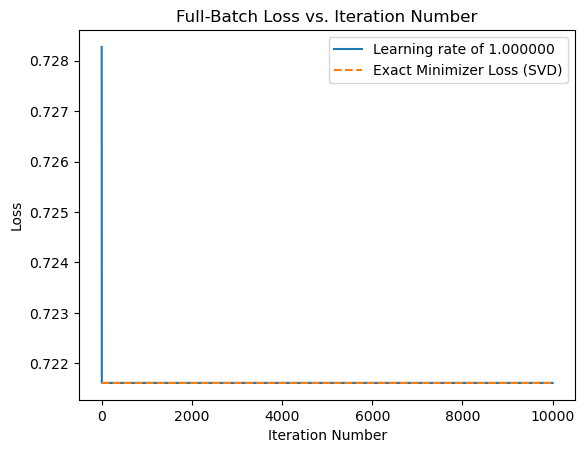

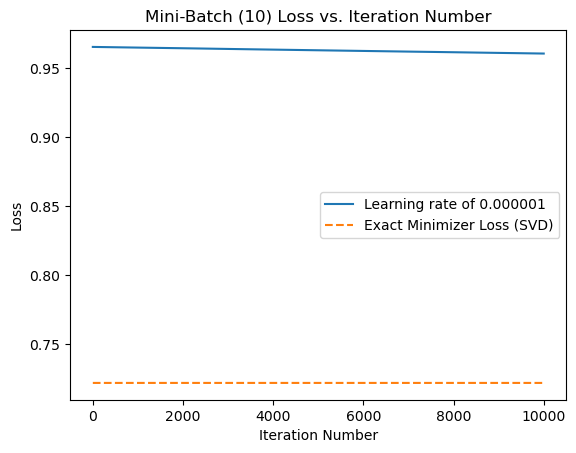

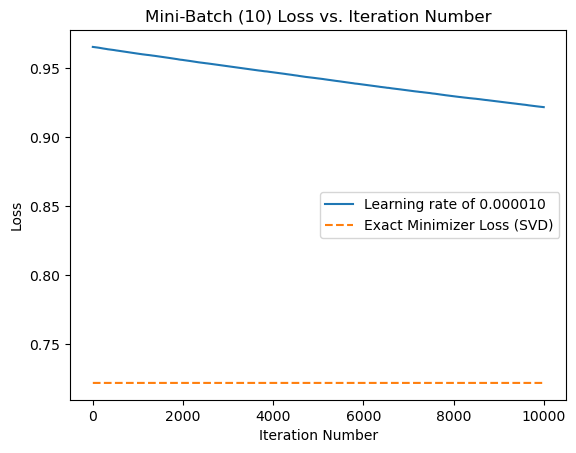

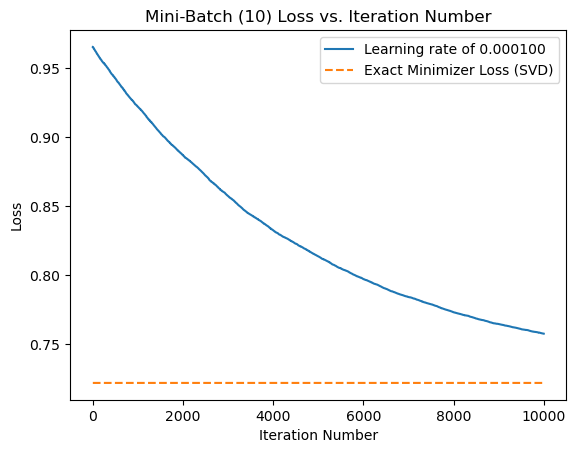

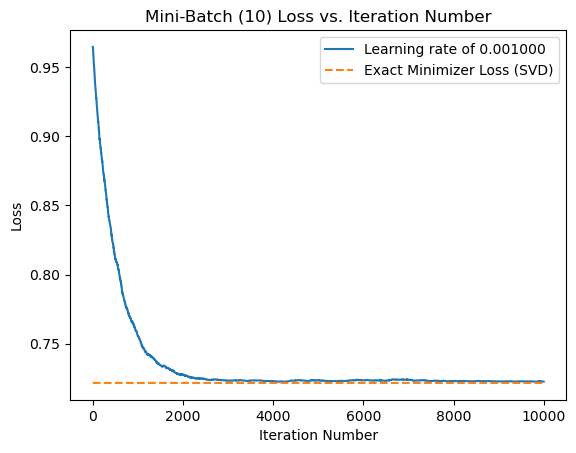

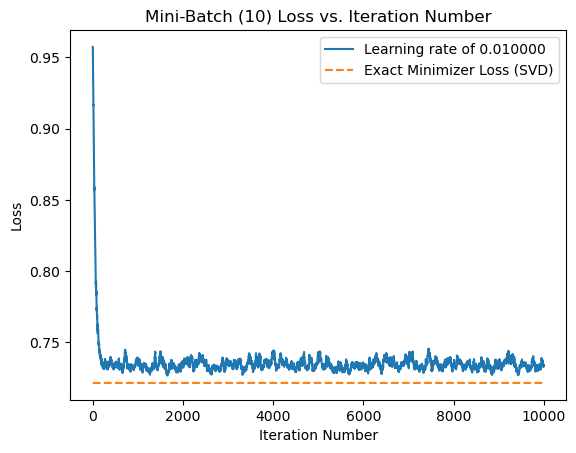

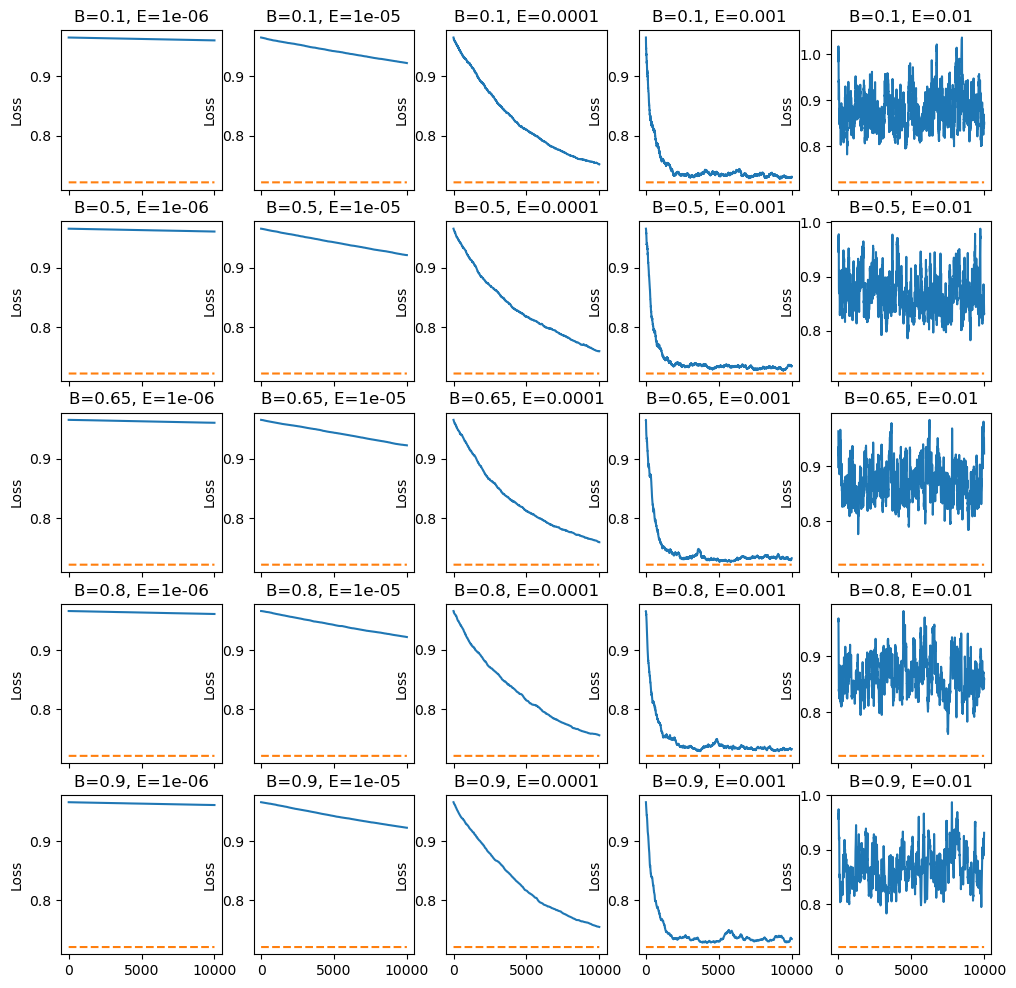

In [20]:
def fullbatchGD(x_train, y_train, x_test, y_test):
    '''Use objective function based on l2 loss and fhat = Xw'''
    eta_opts = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1]  # learning rates to test
    w_decision = np.zeros((x_train.shape[1], len(eta_opts)))
    N = 10000  # iterations
    loss_hist = np.empty([N, len(eta_opts)])
    rmse = np.zeros((len(eta_opts), 1))

    # Get optimal result using SVD to compare (as from A1)
    U, S, V = svd(x_train, full_matrices=False)
    opt_w = V.T.dot(U.T.dot(y_train)/(S.reshape(-1, 1)))
    f_hat = x_train.dot(opt_w)
    optimal_loss = np.mean(np.square(f_hat - y_train))

    for i, eta in enumerate(eta_opts):
        # Iterate through different values of eta to compare results
        printed = False
        t0 = time()
        w = np.zeros((x_train.shape[1], 1))  # w is (D+1)x1
        for j in range(N):
            # Do N iterations of gradient descent
            gradients = (x_train.T.dot(x_train.dot(w)-y_train)) / (x_train.shape[0])
            w = w - eta*gradients
            loss_hist[j, i] = np.mean(np.square(x_train.dot(w)-y_train))

            if math.isclose(loss_hist[j, i], optimal_loss, rel_tol=1e-3) and printed == False:
                printed = True
                tf = time() - t0
                print(f'Time of convergence: {tf} for eta={eta} at iteration {j} (Full Batch)')

        w_decision[:, i] = w.reshape(-1,)
        rmse[i] = np.sqrt(np.mean(np.square(x_train.dot(w)-y_train)))
        # Plot iteration vs. loss
        iterations = np.arange(0, N)
        plt.figure()
        plt.title('Full-Batch Loss vs. Iteration Number')
        plt.plot(iterations, loss_hist[:, i], label='Learning rate of %f' % eta)
        plt.plot(iterations, np.full((N, 1), optimal_loss), label='Exact Minimizer Loss (SVD)', ls='--')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.legend(loc=0)

    min_ind = np.unravel_index(np.argmin(rmse, axis=None), rmse.shape)
    best_w = w_decision[:, min_ind[0]]
    test_rmse = np.sqrt(np.mean(np.square(x_test.dot(best_w) - y_test)))

    return test_rmse

def stochasticGD(x_train, y_train, x_test, y_test, b):
    '''Batch based version of GD for time complexity improvements'''
    np.random.seed(21)

    eta_opts = [0.000001, 0.00001, 0.0001, 0.001, 0.01]  # learning rates to test
    w_decision = np.zeros((x_train.shape[1], len(eta_opts)))
    N = 10000  # iterations
    loss_hist = np.empty([N, len(eta_opts)])
    rmse = np.zeros((len(eta_opts), 1))

    # Get optimal result using SVD to compare (as from A1)
    U, S, V = svd(x_train, full_matrices=False)
    opt_w = V.T.dot(U.T.dot(y_train)/(S.reshape(-1, 1)))
    f_hat = x_train.dot(opt_w)
    optimal_loss = np.mean(np.square(f_hat - y_train))

    for i, eta in enumerate(eta_opts):
        # Iterate through different values of eta to compare results
        w = np.zeros((x_train.shape[1], 1))  # w is (D+1)x1
        t0 = time()
        printed = False
        for j in range(N):
            # Do N iterations of gradient descent with b sized batches per iteration
            batch = np.random.choice(x_train.shape[0], b)
            gradients = (x_train[batch].T.dot(x_train[batch].dot(w)-y_train[batch]))/(x_train[batch].shape[0])
            w = w - eta*gradients
            loss_hist[j, i] = np.mean(np.square(x_train.dot(w)-y_train))

            if math.isclose(loss_hist[j, i], optimal_loss, rel_tol=1e-2) and printed == False:
                printed = True
                tf = time() - t0
                print(f'Time of convergence: {tf} for eta={eta} at iteration {j} (Mini Batch {b})')

        w_decision[:, i] = w.reshape(-1,)
        rmse[i] = np.sqrt(np.mean(np.square(x_train[batch].dot(w)-y_train[batch])))
        # Plot iteration vs. loss
        iterations = np.arange(0, N)
        plt.figure()
        plt.title('Mini-Batch (%d) Loss vs. Iteration Number' % b)
        plt.plot(iterations, loss_hist[:, i], label='Learning rate of %f' % eta)
        plt.plot(iterations, np.full((N, 1), optimal_loss), label='Exact Minimizer Loss (SVD)', ls='--')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.legend(loc=0)

    min_ind = np.unravel_index(np.argmin(rmse, axis=None), rmse.shape)
    best_w = w_decision[:, min_ind[0]]
    test_rmse = np.sqrt(np.mean(np.square(x_test.dot(best_w) - y_test)))

    return test_rmse

def stochasticGD_momentum(x_train, y_train, x_test, y_test, b):
    '''Stochastic Gradient Descent with momentum'''
    np.random.seed(21)

    eta_opts = [0.000001, 0.00001, 0.0001, 0.001, 0.01]  # learning rates to test
    beta_opts = [0.1, 0.5, 0.65, 0.8, 0.9] # momentum hyperparameters to try
    w_decision = np.zeros((x_train.shape[1], len(eta_opts)))
    N = 10000  # iterations
    loss_hist = np.empty([N, len(eta_opts)])
    rmse = np.zeros((len(eta_opts), len(beta_opts)))

    # Get optimal result using SVD to compare (as from A1)
    U, S, V = svd(x_train, full_matrices=False)
    opt_w = V.T.dot(U.T.dot(y_train)/(S.reshape(-1, 1)))
    f_hat = x_train.dot(opt_w)
    optimal_loss = np.mean(np.square(f_hat - y_train))

    # Initialize plots
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12), sharex=True)

    for k, beta in enumerate(beta_opts):
        # Iterate through momentum values to determine optimal hyperparameter
        prev_grad = np.zeros((x_train.shape[1], 1)) 
        for i, eta in enumerate(eta_opts):
            # Iterate through different values of eta to compare results
            w = np.zeros((x_train.shape[1], 1))  # w is (D+1)x1
            t0 = time()
            printed = False
            for j in range(N):
                # Do N iterations of gradient descent with b sized batches per iteration
                batch = np.random.choice(x_train.shape[0], b)
                # Momentum gradient representation
                gradients = beta*prev_grad + (1-beta)*(x_train[batch].T.dot(x_train[batch].dot(w)-y_train[batch]))/(x_train[batch].shape[0])
                w = w - eta*gradients
                prev_grad = gradients
                loss_hist[j, i] = np.mean(np.square(x_train.dot(w)-y_train))

                if math.isclose(loss_hist[j, i], optimal_loss, rel_tol=1e-2) and printed == False:
                    printed = True
                    tf = time() - t0
                    print(f'Time of convergence: {tf} for eta={eta} at iteration {j} (Mini Batch {b}, Beta={beta})')

            w_decision[:, i] = w.reshape(-1,)
            rmse[i, k] = np.sqrt(np.mean(np.square(x_train[batch].dot(w)-y_train[batch])))
            # Plot iteration vs. loss
            iterations = np.arange(0, N)
            axs[k,i].set_title(f'B={beta}, E={eta}')
            axs[k,i].plot(iterations, loss_hist[:, i])
            axs[k,i].plot(iterations, np.full((N, 1), optimal_loss), ls='--')
            axs[k,i].set_ylabel('Loss')

    min_ind = np.unravel_index(np.argmin(rmse, axis=None), rmse.shape)
    best_w = w_decision[:, min_ind[0]]
    best_beta = beta_opts[min_ind[1]]
    test_rmse = np.sqrt(np.mean(np.square(x_test.dot(best_w) - y_test)))

    return test_rmse, best_beta

def runQ1(mini_batch):
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
    # Use only first 1000 points in training set for predictions
    x_train, y_train = x_train[:1000], y_train[:1000]
    # Add bias feature of 1s to form fhat = Xw
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0],1)), x_test))

    # Full batch run
    fullbatch_rmse = fullbatchGD(x_train, y_train, x_test, y_test)
    minibatch_rmse = stochasticGD(x_train, y_train, x_test, y_test, mini_batch)
    momentum_rmse, beta = stochasticGD_momentum(x_train, y_train, x_test, y_test, 1)

    return fullbatch_rmse, minibatch_rmse, momentum_rmse, beta

runQ1(10)

**Question 2 - Logistic Regression Model with Bernoulli Likelihood**

In [ ]:
def mleRegression(x_train, y_train, x_test, y_test, minibatch):
    '''Find MLE using full batch GD and stochastic GD with mini-batch size of 1'''
    pass

def runQ2(minibatch):
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

    # Format Data
    y_train, y_valid, y_test = y_train[:,(1,)], y_valid[:,(1,)], y_test[:,(1,)]
    x_train = np.vstack([x_train, x_valid])
    y_train = np.vstack([y_train, y_valid])
    # Add bias feature 
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0],1)), x_test))
    
    test_acc_full, test_log_full = mleRegression(x_train, y_train, x_test, y_test, False)
    test_acc_batch, test_log_batch = mleRegression(x_train, y_train, x_test, y_test, True)

    return test_acc_full, test_acc_batch, test_log_full, test_log_batch